### Intall Dependencies
Install numpy, pandas.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Here I am going to use Unsloth's Gemma2 model. Why Unsloth....?
* Unsloth models are optimized for faster training and reduced memory usage, making them more efficient for fine-tuning large language models. While their primary focus is on training, these optimizations can indirectly lead to benefits during inference as well.

* Here's how Unsloth models can be advantageous for inference:

1. Reduced Memory Footprint: Unsloth employs techniques like quantization and efficient gradient computation to reduce the memory footprint of models during training significantly. This smaller memory footprint can persist even after fine-tuning, potentially allowing for:

1. Faster loading times: Models can be loaded into memory quicker, reducing latency at the start of inference.
1. Larger batch sizes: You can process more inference requests simultaneously due to lower memory usage per request.
1. Deployment on less powerful hardware: Models might be deployable on devices with less RAM, expanding accessibility.
1. Optimized Kernels and Operations: Unsloth optimizes the underlying operations and kernels used in the model. These optimizations, designed for training speed, can sometimes translate to faster inference speeds, though this is not their primary goal.

* Focus on Efficiency: The overall focus of Unsloth on efficiency and optimization can lead to models that are generally more streamlined. This can have positive knock-on effects for inference performance.

* It's important to note:

Unsloth's main strength is in efficient training, not specifically inference optimization. For pure inference speed, other techniques like model distillation, pruning, or specialized inference engines might be more directly beneficial.
The extent of inference improvement from using Unsloth can vary depending on the specific model, hardware, and inference setup.

# Some more dependencies....

In [ ]:
# %%capture
# !pip install pip3-autoremove
# !pip-autoremove torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 
# # !pip install -q 'unsloth==2025.2.4'
# # #!pip uninstall trl -y && pip install --no-cache-dir --force-reinstall --no-deps "trl<0.15.0"
# # !pip uninstall -q transformers -y
# # !pip install -q 'transformers==4.47.1'
# !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
# !pip install --no-deps cut_cross_entropy unsloth_zoo
# !pip install sentencepiece protobuf datasets
# !pip install --no-deps unsloth

# import os
# os.environ["WANDB_DISABLED"] = "true"

In [ ]:
%%capture
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth
#!pip install accelerate

import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
#!pip show xformers

In [ ]:
import torch

if torch.cuda.is_available():
    print("Number of GPUs available:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

In [ ]:
# import torch
# print(torch.__version__)  # To check CUDA version
# print(torch.cuda.get_device_capability())  # To get GPU capability

In [ ]:
!pip show unsloth

In [ ]:
!pip show accelerate

### Let us begin the fine tuning process.
I have initialized the maximum sequence length to 512, although you are free to explore. Given the memory constraints, I selected the below parameters.

In [ ]:
# !pip install --upgrade huggingface_hub transformers

In [ ]:
import unsloth
from unsloth import FastLanguageModel
import torch
#import torchvision
max_seq_length = 1024 
dtype = None 
load_in_4bit = True 

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2-9b",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

A peak into target modules and their functions:

In [ ]:
# import accelerate
# import unsloth

# print("Accelerate version:", accelerate.__version__)
# print("Unsloth imported successfully")

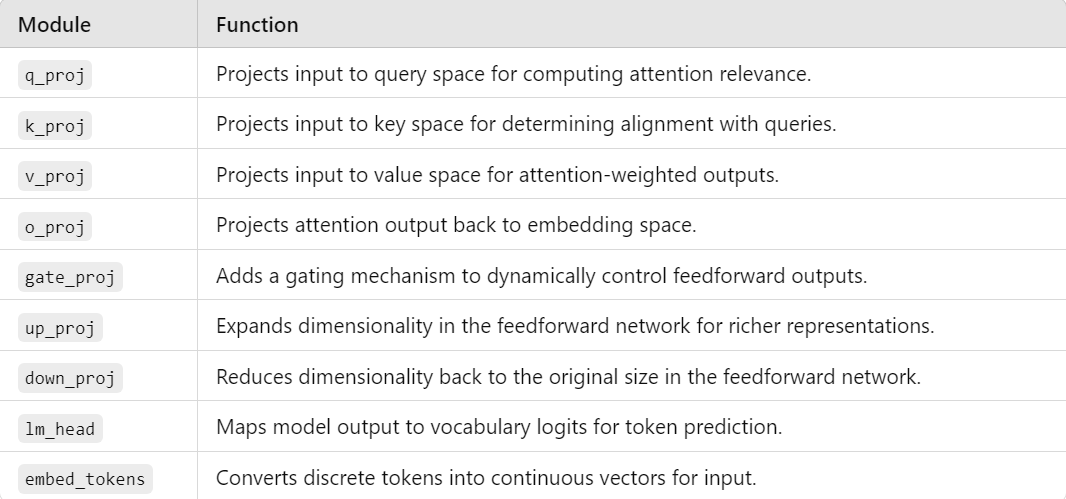

## What is r value? How to assign a value to lora_alpha? These are the same question that aroused into my mind when I started, so let's get delve into the same!
### r Value
Definition: The r value represents the rank of the low-rank decomposition used in the LoRA (Low-Rank Adaptation) technique. It determines how many low-rank matrices are employed to approximate the weight updates during fine-tuning.
Impact: A higher r value allows for capturing more information from the original model, potentially improving accuracy on complex tasks. However, it also increases memory usage and computational time, leading to a risk of overfitting if set too high. Common suggestions for r include values like 8, 16, or even up to 128 depending on the task complexity and available resourc

### lora_alpha
Definition: The lora_alpha parameter is a scaling factor that adjusts the contribution of the low-rank matrices during training. It effectively controls how much influence the changes made by LoRA have on the original model weights.
Impact: A larger lora_alpha increases the impact of the low-rank updates, which can accelerate convergence but may also lead to instability or overfitting. It is often recommended to set lora_alpha to be equal to or double that of r (e.g., if r is 16, then lora_alpha could be set to 16 or 32) to maintain a balanced training dynamices

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 34,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

### About Dataset :
This dataset contains the vast data from a large corpus of news feeds revolving around Marathi speaking state of Maharashtra, one of the prominent states powering India in every aspects. Dataset also included sentences from basic Marathi day to day words to complex on topics like Agriculture, climate, politics, media & entertainment, sports, some basic Marathi terms, names of fruits and vegetables, etc. My efforts was to feed the model with a comprehensive knowledge about Marathi language and it's different shades!

In [ ]:
df_mar = pd.read_csv("/kaggle/input/peshwaai-marathi-english-translation/English-to-Marathi.csv")

In [ ]:
from datasets import Dataset
# Combine English and Marathi columns into a 'text' column
df_mar["text"] = df_mar["English"] + " || " + df_mar["Marathi"]

# Convert the pandas DataFrame into a Hugging Face Dataset
dataset_mar = Dataset.from_pandas(df_mar)

In [ ]:
# from datasets import Dataset
# import random

# # Combine English and Marathi columns into a 'text' column
# df_mar["text"] = df_mar["English"] + " || " + df_mar["Marathi"]

# # Convert the pandas DataFrame into a Hugging Face Dataset
# dataset_mar = Dataset.from_pandas(df_mar)

# # Set a random seed for reproducibility
# random.seed(42)

# # Define the size of the subset
# subset_size = 20000  # Choose how many samples you want

# # Randomly select indices for the subset
# selected_indices = random.sample(range(len(dataset_mar)), subset_size)

# # Create a subset of the dataset using Hugging Face methods
# subset_dataset = dataset_mar.select(selected_indices)

In [ ]:
# Convert the pandas DataFrame into a Hugging Face Dataset
custom_prompt = """Below is a document containing English text and its Marathi translation. 
                   Your task is to understand the language complexity, and learn the marathi 
                   semantic content for future translation from English to Marathi language fluently.

### English:
{}

### Marathi:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token  

# Function to format the prompts
def formatting_prompts_func(examples):
    english_texts = examples["English"]
    marathi_texts = examples["Marathi"]
    outputs = [""] * len(english_texts) 

    formatted_texts = []
    for english_text, marathi_text, output in zip(english_texts, marathi_texts, outputs):
        formatted_text = custom_prompt.format(english_text, marathi_text, output) + EOS_TOKEN 
        formatted_texts.append(formatted_text)

    return {"text": formatted_texts}

### EOS tokens?
Adding an end-of-sequence (EOS) token to formatted text is essential for several reasons in natural language processing tasks, particularly in model training and generation.
1.	Termination Signal: The EOS token serves as a clear signal to the model that it has reached the end of a sequence. This is crucial because it helps the model understand when to stop generating further text, preventing it from producing endless or nonsensical output2. Without this token, the model may continue generating text indefinitely, leading to repetition and irrelevant content.
2.	Coherence and Structure: By marking the end of a sequence, the EOS token aids in maintaining coherent and well-structured outputs. It guides the model in producing complete thoughts or sentences, ensuring that the generated text is meaningful and contextually appropriate.
3.	Training Efficiency: In training scenarios, including EOS tokens helps models learn to recognize boundaries within sequences. This can enhance their ability to manage varying lengths of output effectively, as they can learn to predict when a sequence should end based on the presence of the EOS token. This capability is particularly beneficial in tasks like machine translation and summarization.
4.	Model Performance: Empirical studies have shown that models trained with EOS tokens tend to perform better on various tasks compared to those without them. The EOS token encourages models to track sequence length and manage their hidden states more effectively during generation, which can lead to improved performance on tasks requiring precise output lenhs
gths


In [ ]:
# # Apply the `map` function to the subset
dataset_mar = dataset_mar.map(formatting_prompts_func, batched=True)

In [ ]:
# tokenized_dataset = subset_dataset.map(
#     lambda x: tokenizer(x["text"], padding="max_length", truncation=True, return_tensors="pt"),
#     batched=True
# ) # Let's leave it for some time...

In [ ]:
# # Tokenize the dataset
# def tokenize_function(examples):
#     tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
#     tokens["labels"] = tokens["input_ids"].copy()  # Add labels for language modeling
#     return tokens

# # Apply tokenization
# tokenized_dataset = subset_dataset.map(tokenize_function, batched=True)
# tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
# import os
# os.environ["TORCH_INDUCTOR_USE_TRITON"] = "1"

In [ ]:
# print(tokenized_dataset.format)
# print(tokenized_dataset[0])

In [ ]:
# from trl import SFTTrainer
# from transformers import TrainingArguments
# import torch
# from unsloth import is_bfloat16_supported
# from accelerate import Accelerator

# # Initialize Accelerator
# accelerator = Accelerator()

# device = accelerator.device #get the correct device.

# model.to(device)

# # Training Arguments
# training_args = TrainingArguments(
#     per_device_train_batch_size=4,
#     gradient_accumulation_steps=4,
#     num_train_epochs=3,
#     warmup_steps=10,
#     max_steps=500,
#     learning_rate=2e-6,
#     fp16=not is_bfloat16_supported(),
#     bf16=is_bfloat16_supported(),
#     logging_steps=10,
#     optim="adamw_8bit",
#     weight_decay=0.01,
#     lr_scheduler_type="cosine",
#     seed=2802,
#     output_dir="outputs",
# )

# # Trainer
# trainer = SFTTrainer(
#     model=model,
#     tokenizer=tokenizer,
#     train_dataset=dataset_mar,
#     dataset_text_field="text",
#     max_seq_length=max_seq_length,
#     dataset_num_proc=1,
#     packing=False,
#     args=training_args,
# )

# # Prepare model, optimizer, and dataloader with accelerate
# trainer.model, trainer.optimizer, trainer.train_dataset = accelerator.prepare(
#     trainer.model, trainer.optimizer, trainer.train_dataset
# )

# # Train
# # trainer.train()

# # # Save Model
# # trainer.model.save_pretrained("outputs") #or trainer.save_model()

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
import torch
from unsloth import is_bfloat16_supported

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move to GPU or CPU as required

# Define trainer with consistent precision and multi-GPU support
trainer = SFTTrainer(
    model=model,  
    tokenizer=tokenizer,
    train_dataset=dataset_mar,  # Processed dataset
    dataset_text_field="text",  # Combined 'text' column
    max_seq_length=max_seq_length,
    dataset_num_proc=1,
    packing=False,  # Can make training faster for short sequences
    args=TrainingArguments(
        per_device_train_batch_size=4,  # Adjust for memory constraints
        gradient_accumulation_steps=4,  # Manage gradients effectively
        num_train_epochs=3,  # Number of training epochs
        warmup_steps=10,
        max_steps=500,  
        learning_rate=2e-6,  # Optimized learning rate, adjust as needed
        fp16=not is_bfloat16_supported(),  
        bf16=is_bfloat16_supported(),  
        logging_steps=10,
        optim="adamw_8bit",  # Memory-efficient optimizer
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=2802,
        output_dir="outputs",  # Output directory
    ),
)


## SFTTrainer Parameters
* **Model Configuration**
1. model.half() / is_bfloat16_supported(): Uses fp16 or bf16 precision for memory efficiency if supported by hardware.
1. Tokenizer
tokenizer: Tokenizer instance matching the model for input preprocessing.
* **Dataset**:
1. train_dataset: The dataset used for training.
1. dataset_text_field: Field name in the dataset containing text data.
1. max_seq_length: Maximum tokenized sequence length.
1. dataset_num_proc: Number of processes for dataset preprocessing.
1. packing: Packs shorter sequences for faster training if True.

### TrainingArguments
* **Batching**:

1. per_device_train_batch_size: Batch size per device (reduce for memory limits).
1. gradient_accumulation_steps: Accumulates gradients for larger effective batch size.
* **Training Duration**:
1. num_train_epochs: Number of full passes over the dataset.
1. max_steps: Maximum training steps (overrides num_train_epochs if both are set).
* **Optimization**:

1. learning_rate: Step size for weight updates (lower for stability).
1. weight_decay: L2 regularization to prevent overfitting.
1. optim: Optimizer, e.g., adamw_8bit for memory-efficient training.
* **Precision**:

1. fp16 / bf16: Enables mixed precision for faster, memory-efficient training if hardware supports it.
* **Warmup and Scheduling**:

1. warmup_steps: Steps for linear learning rate warmup.
1. lr_scheduler_type: Learning rate schedule type (cosine here).
1. Logging and Reproducibility:

1. logging_steps: Frequency of logging metrics.
1. seed: Random seed for reproducibility.
* **Output**:

output_dir: Directory to save training artifacts like checkpoints and logs.

In [ ]:
# Train the model.
trainer_stats = trainer.train()

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

### Below are the steps to check the model output. I gave a sample complex sentence for the model to translate into Marathi language.

In [ ]:
FastLanguageModel.for_inference(model)
custom_prompt = """Translate the following English text into Marathi:
English: {0}
Marathi: {1}
"""

In [ ]:
inputs = tokenizer(
    [
        custom_prompt.format(
            "The rapid advancement of artificial intelligence has the potential to revolutionize industries, from healthcare to finance, but it also raises ethical concerns regarding job displacement and algorithmic bias.",  # English text
            ""  # Leave the Marathi translation empty for generation
        )
    ],
    padding=True, truncation=True, return_tensors="pt"
).to("cuda")

In [ ]:
import time 

start_time = time.time()
# Generate outputs
outputs = model.generate(**inputs, max_new_tokens=128,use_cache=True)

# Decode the outputs
decoded_output = tokenizer.batch_decode(outputs)
end_time = time.time()

print("Output (Marathi):", decoded_output)
print(f"Inference Time: {end_time - start_time:.4f} seconds")

In [ ]:
import os
import json
from unsloth import is_bfloat16_supported

# Define the configuration
config = {
    "model": "unsloth/gemma-2-9b",
    "training_type": "SFT and DPO",
    "max_seq_length": 1024,
    "dtype": "bfloat16" if is_bfloat16_supported() else "float16",
    "training_args": {
        "sft": {
            "learning_rate": 2e-6,
            "batch_size": 4,
            "gradient_accumulation_steps": 4,
            "num_train_epochs": 3,
            "scheduler": "cosine",
            "optim": "adamw_8bit",
            "seed": 2802,
        },
    }
}
# Ensure the outputs directory exists
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save to config.json
config_path = os.path.join(output_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print(f"Config saved at {config_path}")

In [ ]:
model.save_pretrained("./Gemma2-Marathi")
tokenizer.save_pretrained("./Gemma2-Marathi")

In [ ]:
print(model.config)

In [ ]:
from datasets import load_dataset

# Load the Marathi-English parallel dataset
dataset = load_dataset("ai4bharat/samanantar", "mr")

# Extract 10 English-Marathi pairs for evaluation
eval_samples = dataset["train"].select(range(10))  # First 10 samples
test_texts = eval_samples["src"]  # English texts
references = eval_samples["tgt"]  # Marathi references

In [ ]:
# def translate_texts(model, tokenizer, texts):
#     model.eval()
#     translated_texts = []
#     for text in texts:
#         inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
#         with torch.no_grad():
#             output_ids = model.generate(**inputs, max_length=100)
#         translated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
#         translated_texts.append(translated_text)
#     return translated_texts
def translate_texts(model, tokenizer, texts):
    model.eval()
    translated_texts = []
    
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
        with torch.no_grad():
            output_ids = model.generate(
                **inputs, 
                max_length=128, 
                do_sample=True,  # Use sampling instead of beam search
                temperature=0.7,  # Adjust temperature for diversity
                top_k=50,  # Consider top 50 tokens
                top_p=0.9  # Nucleus sampling
            )
        
        translated_texts.append(tokenizer.decode(output_ids[0], skip_special_tokens=True))
    
    return translated_texts

# Generate translations
generated_translations = translate_texts(model, tokenizer, test_texts)

In [ ]:
# test_texts = dataset["train"]["src"][:100]  # Use "src" for English
# references = dataset["train"]["tgt"][:100]  # Use "tgt" for Marathi

# # Marathi ground-truth references
# generated_translations = translate_texts(model, tokenizer, test_texts)

In [ ]:
# print(generated_translations)

In [ ]:
!pip install evaluate

In [ ]:
# from evaluate import load

# # Load BLEU metric
# bleu = load("bleu")

# # Format references correctly
# references = [[ref] for ref in references]  # Each reference must be a list of lists

# # Compute BLEU score
# bleu_score = bleu.compute(predictions=generated_translations, references=references)

# print(f"BLEU Score: {bleu_score['bleu']}")

In [ ]:
!pip install sacrebleu

In [ ]:
from sacrebleu import corpus_bleu

# Format references correctly for BLEU scoring
formatted_references = [[ref] for ref in references]

# Compute BLEU score
bleu_score = corpus_bleu(generated_translations, formatted_references)
print(f"BLEU Score: {bleu_score.score:.2f}")

In [ ]:
rouge = load_metric("rouge")

rouge_score = rouge.compute(predictions=generated_translations, references=references)
print(f"ROUGE Score: {rouge_score}")

In [ ]:
from evaluate import load
chrf = load("chrf")
score = chrf.compute(predictions=generated_translations, references=references)
print(f"CHRF Score: {score['score']}")

### Use Cases for Your Model

1. History Q&A: Answer questions about the Peshwas and Marathi history.
1. Content Generation: Generate Marathi content for blogs, educational materials, or storytelling.
1. Interactive Chatbot: Use the model as a conversational assistant for history enthusiasts.